In [2]:
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

%matplotlib notebook

register_matplotlib_converters()

In [3]:
def ComputeReturnAndVolatility(data):
    mean = np.mean(data)
    sigma = np.std(data)
    return mean, sigma

In [4]:
# 从 Yahoo Finance 下载历史数据

tickers = [
    'SPY',   # S&P500 ETF
    'IEF',   # 7-10 year US treasury bond ETF
    'GLD',
    'QQQ'
]

data = yf.download(
    tickers = tickers,
    period = 'max',
    interval = '1d',
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True).dropna()

[*********************100%***********************]  4 of 4 completed


In [5]:
sp500 = data['SPY']['Close'].to_numpy()
bond = data['IEF']['Close'].to_numpy()
gld = data['GLD']['Close'].to_numpy()
qqq = data['QQQ']['Close'].to_numpy()

# 计算 5 个交易日的累计收益
sp500_wk = sp500[::5]
bond_wk = bond[::5]
gld_wk = gld[::5]
qqq_wk = qqq[::5]
sp500_wk_ret = sp500_wk[1:]/sp500_wk[:-1]
bond_wk_ret = bond_wk[1:]/bond_wk[:-1]
gld_wk_ret = gld_wk[1:]/gld_wk[:-1]
qqq_wk_ret = qqq_wk[1:]/qqq_wk[:-1]

index_wk = data.index[::5]
index_wk = index_wk[1:]

assert(len(index_wk)==len(bond_wk_ret))

Minimum variance:  4.693629876820218e-05
         Weights:  [0.17142422 0.82857578]
Mean Return of Optimal Portfolio:  1.0011863490052122


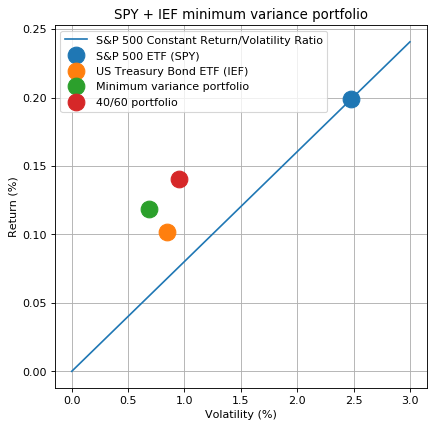

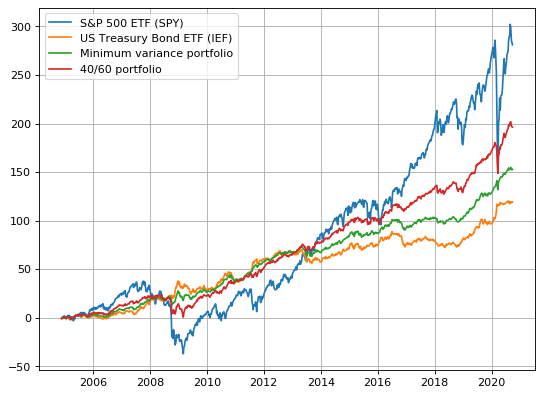

In [6]:
num_of_assets = 2

returns = np.array([sp500_wk_ret, bond_wk_ret])
covmat = np.cov(returns)
mu = np.mean(returns, axis=1)

weights = cp.Variable(num_of_assets)
constraints = [np.ones(num_of_assets) @ weights == 1]
objective = cp.Minimize(cp.quad_form(weights, covmat))

problem = cp.Problem(objective, constraints)
problem.solve()

portfolio = np.sum(weights.value * returns.T, axis=1)
portfolio_40_60 = np.sum([0.4, 0.6] * returns.T, axis=1)

sp500_ret_mean, sp500_ret_sigma = ComputeReturnAndVolatility(sp500_wk_ret-1)
bond_ret_mean, bond_ret_sigma = ComputeReturnAndVolatility(bond_wk_ret-1)
port_ret_mean, port_ret_sigma = ComputeReturnAndVolatility(portfolio-1)
port46_ret_mean, port46_ret_sigma = ComputeReturnAndVolatility(portfolio_40_60-1)

print("Minimum variance: ", problem.value)
print("         Weights: ", weights.value)
print("Mean Return of Optimal Portfolio: ", np.mean(portfolio))

sp500_line_x = np.linspace(0, 3, 5)
sp500_line_y = sp500_line_x * sp500_ret_mean / sp500_ret_sigma

fig1 = plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.plot(sp500_line_x, sp500_line_y, color='C0')
ax.plot(sp500_ret_sigma * 100, sp500_ret_mean * 100, '.', color='C0', markersize=30)
ax.plot(bond_ret_sigma * 100, bond_ret_mean * 100, '.', color='C1', markersize=30)
ax.plot(port_ret_sigma * 100, port_ret_mean * 100, '.', color='C2', markersize=30)
ax.plot(port46_ret_sigma * 100, port46_ret_mean * 100, '.', color='C3', markersize=30)
ax.legend(['S&P 500 Constant Return/Volatility Ratio', 
           'S&P 500 ETF (SPY)', 
           'US Treasury Bond ETF (IEF)',
           'Minimum variance portfolio',
           '40/60 portfolio' ])

ax.grid()
ax.set_title('SPY + IEF minimum variance portfolio')
ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Return (%)')

fig2 = plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = fig2.add_subplot(1,1,1)
ax.plot(index_wk, (np.cumprod(sp500_wk_ret)-1)*100, color='C0')
ax.plot(index_wk, (np.cumprod(bond_wk_ret)-1)*100, color='C1')
ax.plot(index_wk, (np.cumprod(portfolio)-1)*100, color='C2')
ax.plot(index_wk, (np.cumprod(portfolio_40_60)-1)*100, color='C3')
ax.legend([ 'S&P 500 ETF (SPY)', 
           'US Treasury Bond ETF (IEF)',
           'Minimum variance portfolio',
           '40/60 portfolio' ])
ax.grid()

Minimum variance:  0.00032970465868407197
         Weights:  [0.50921057 0.49078943]
Mean Return of Optimal Portfolio:  1.0020138340775466


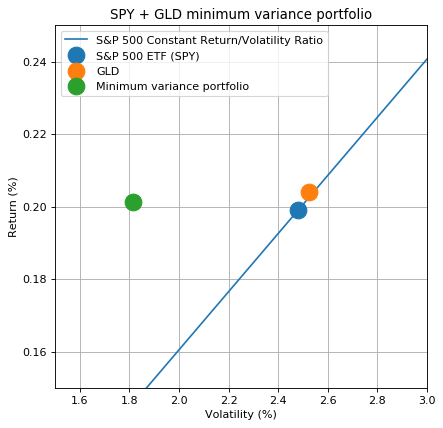

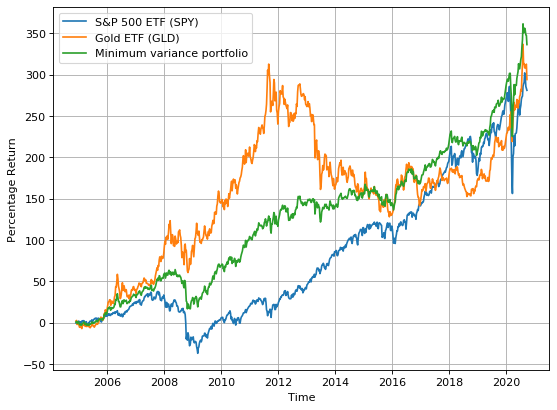

In [11]:
num_of_assets = 2

returns = np.array([sp500_wk_ret, gld_wk_ret])
covmat = np.cov(returns)
mu = np.mean(returns, axis=1)

weights = cp.Variable(num_of_assets)
constraints = [np.ones(num_of_assets) @ weights == 1]
objective = cp.Minimize(cp.quad_form(weights, covmat))

problem = cp.Problem(objective, constraints)
problem.solve()

portfolio = np.sum(weights.value * returns.T, axis=1)

sp500_ret_mean, sp500_ret_sigma = ComputeReturnAndVolatility(sp500_wk_ret-1)
gld_ret_mean, gld_ret_sigma = ComputeReturnAndVolatility(gld_wk_ret-1)
port_ret_mean, port_ret_sigma = ComputeReturnAndVolatility(portfolio-1)

print("Minimum variance: ", problem.value)
print("         Weights: ", weights.value)
print("Mean Return of Optimal Portfolio: ", np.mean(portfolio))

sp500_line_x = np.linspace(0, 3, 5)
sp500_line_y = sp500_line_x * sp500_ret_mean / sp500_ret_sigma

fig1 = plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.plot(sp500_line_x, sp500_line_y, color='C0')
ax.plot(sp500_ret_sigma * 100, sp500_ret_mean * 100, '.', color='C0', markersize=30)
ax.plot(gld_ret_sigma * 100, gld_ret_mean * 100, '.', color='C1', markersize=30)
ax.plot(port_ret_sigma * 100, port_ret_mean * 100, '.', color='C2', markersize=30)
ax.legend(['S&P 500 Constant Return/Volatility Ratio', 
           'S&P 500 ETF (SPY)', 
           'GLD',
           'Minimum variance portfolio',
           ])

ax.grid()
ax.set_title('SPY + GLD minimum variance portfolio')
ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Return (%)')
ax.set_xlim([1.5, 3])
ax.set_ylim([0.15, 0.25])

fig2 = plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = fig2.add_subplot(1,1,1)
ax.plot(index_wk, (np.cumprod(sp500_wk_ret)-1)*100, color='C0')
ax.plot(index_wk, (np.cumprod(gld_wk_ret)-1)*100, color='C1')
ax.plot(index_wk, (np.cumprod(portfolio)-1)*100, color='C2')
ax.legend([ 'S&P 500 ETF (SPY)', 
           'Gold ETF (GLD)',
           'Minimum variance portfolio' ])
ax.set_xlabel('Time')
ax.set_ylabel('Percentage Return')
ax.grid()

Minimum variance:  0.000615448782226378
         Weights:  [ 1.02383681 -0.02383681]
Mean Return of Optimal Portfolio:  1.0019658344800433


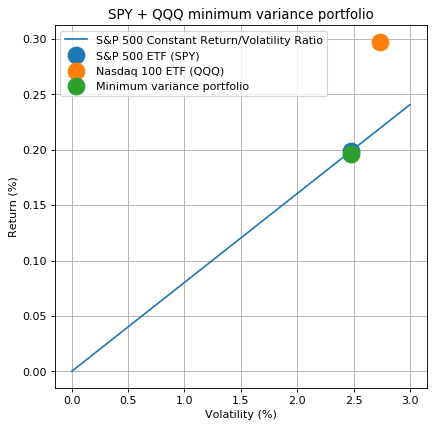

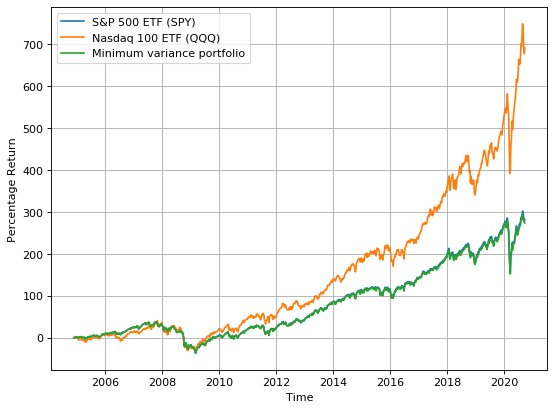

In [15]:
num_of_assets = 2

returns = np.array([sp500_wk_ret, qqq_wk_ret])
covmat = np.cov(returns)
mu = np.mean(returns, axis=1)

weights = cp.Variable(num_of_assets)
constraints = [np.ones(num_of_assets) @ weights == 1]
objective = cp.Minimize(cp.quad_form(weights, covmat))

problem = cp.Problem(objective, constraints)
problem.solve()

portfolio = np.sum(weights.value * returns.T, axis=1)

sp500_ret_mean, sp500_ret_sigma = ComputeReturnAndVolatility(sp500_wk_ret-1)
qqq_ret_mean, qqq_ret_sigma = ComputeReturnAndVolatility(qqq_wk_ret-1)
port_ret_mean, port_ret_sigma = ComputeReturnAndVolatility(portfolio-1)

print("Minimum variance: ", problem.value)
print("         Weights: ", weights.value)
print("Mean Return of Optimal Portfolio: ", np.mean(portfolio))

sp500_line_x = np.linspace(0, 3, 5)
sp500_line_y = sp500_line_x * sp500_ret_mean / sp500_ret_sigma

fig1 = plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.plot(sp500_line_x, sp500_line_y, color='C0')
ax.plot(sp500_ret_sigma * 100, sp500_ret_mean * 100, '.', color='C0', markersize=30)
ax.plot(qqq_ret_sigma * 100, qqq_ret_mean * 100, '.', color='C1', markersize=30)
ax.plot(port_ret_sigma * 100, port_ret_mean * 100, '.', color='C2', markersize=30)
ax.legend(['S&P 500 Constant Return/Volatility Ratio', 
           'S&P 500 ETF (SPY)', 
           'Nasdaq 100 ETF (QQQ)',
           'Minimum variance portfolio',
           ])

ax.grid()
ax.set_title('SPY + QQQ minimum variance portfolio')
ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Return (%)')

fig2 = plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = fig2.add_subplot(1,1,1)
ax.plot(index_wk, (np.cumprod(sp500_wk_ret)-1)*100, color='C0')
ax.plot(index_wk, (np.cumprod(qqq_wk_ret)-1)*100, color='C1')
ax.plot(index_wk, (np.cumprod(portfolio)-1)*100, color='C2')
ax.legend([ 'S&P 500 ETF (SPY)', 
           'Nasdaq 100 ETF (QQQ)',
           'Minimum variance portfolio' ])
ax.set_xlabel('Time')
ax.set_ylabel('Percentage Return')
ax.grid()

SPY vs GLD correlation coefficient:  0.05294250533949738
SPY vs IEF correlation coefficient:  -0.33753798819247655
SPY vs QQQ correlation coefficient:  0.9113683537700441


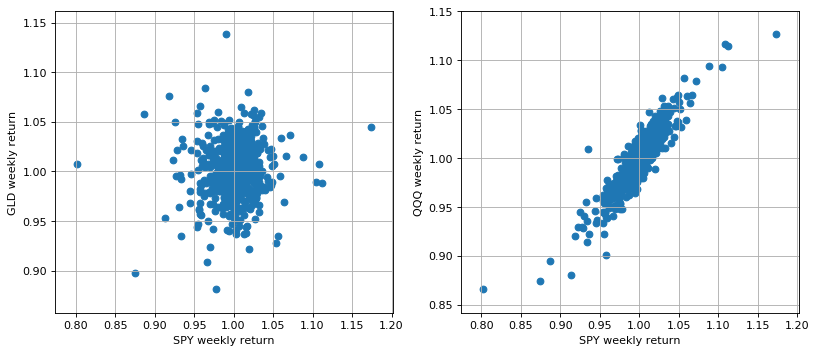

In [12]:
print('SPY vs GLD correlation coefficient: ', np.corrcoef(sp500_wk_ret, gld_wk_ret)[0][1])
print('SPY vs IEF correlation coefficient: ', np.corrcoef(sp500_wk_ret, bond_wk_ret)[0][1])
print('SPY vs QQQ correlation coefficient: ', np.corrcoef(sp500_wk_ret, qqq_wk_ret)[0][1])

fig1 = plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,2,1)
ax.scatter(sp500_wk_ret, gld_wk_ret)
ax.set_xlabel('SPY weekly return')
ax.set_ylabel('GLD weekly return')
ax.grid()

ax = fig1.add_subplot(1,2,2)
ax.scatter(sp500_wk_ret, qqq_wk_ret)
ax.set_xlabel('SPY weekly return')
ax.set_ylabel('QQQ weekly return')
ax.grid()